In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn :: utils
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

# sklearn :: models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost

# sklearn :: evaluation metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

sns.set_style('whitegrid')

# Problem definition

Apply regression models to predict the house pricing

# Load the data

In [2]:
#input
df_pricing = pd.read_csv('data/house_pricing.csv')
print(df_pricing.columns)
df_pricing.head()

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'walking_score',
       'transit_score', 'bike_score', 'median_income', 'mean_income',
       'population'],
      dtype='object')


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,walking_score,transit_score,bike_score,median_income,mean_income,population
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,47.5112,-122.257,1340,5650,24,46.0,22.0,55777.0,65498.0,24092
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,47.7210,-122.319,1690,7639,67,59.0,64.0,47910.0,60487.0,30826
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,47.7379,-122.233,2720,8062,14,36.0,NaN,86310.0,100546.0,20419
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,47.5208,-122.393,1360,5000,74,48.0,51.0,77761.0,95355.0,14770
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,47.6168,-122.045,1800,7503,9,0.0,NaN,134159.0,157543.0,25748


# Feature Engineering 

In [3]:
# zipcode to numerical columns
df_zipcode = pd.get_dummies(df_pricing['zipcode'])
df = pd.concat([df_pricing, df_zipcode], axis=1).fillna(0.0)
print(list(df.columns))
df.head()

['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'walking_score', 'transit_score', 'bike_score', 'median_income', 'mean_income', 'population', 98001, 98002, 98003, 98004, 98005, 98006, 98007, 98008, 98010, 98011, 98014, 98019, 98022, 98023, 98024, 98027, 98028, 98029, 98030, 98031, 98032, 98033, 98034, 98038, 98039, 98040, 98042, 98045, 98052, 98053, 98055, 98056, 98058, 98059, 98065, 98070, 98072, 98074, 98075, 98077, 98092, 98102, 98103, 98105, 98106, 98107, 98108, 98109, 98112, 98115, 98116, 98117, 98118, 98119, 98122, 98125, 98126, 98133, 98136, 98144, 98146, 98148, 98155, 98166, 98168, 98177, 98178, 98188, 98198, 98199]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# feature engineering
X_columns = ['bedrooms', 'bathrooms', 'grade', 'condition', 'sqft_living15', 'sqft_lot15', 'floors', 'walking_score', 'median_income', 'mean_income', 'population'] + list(df_zipcode.columns)
y_column = ['price']

# Model Training

In [5]:
# split the data

df = df.sample(frac=1).reset_index(drop=True)

threshold = 0.8
absolute_threshold = int(len(df)*threshold)

X_train = df.iloc[:absolute_threshold][X_columns]
y_train = df.iloc[:absolute_threshold][y_column]

X_test = df.iloc[absolute_threshold:][X_columns]
y_test = df.iloc[absolute_threshold:][y_column]

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (16932, 81)
y_train (16932, 1)
X_test (4233, 81)
y_test (4233, 1)


In [6]:
# split the data

threshold = 0.8
X = df[X_columns]
y = df[y_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1.0-threshold, shuffle=True)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_test', X_test.shape)
print('y_test', y_test.shape)

X_train (16932, 81)
y_train (16932, 1)
X_test (4233, 81)
y_test (4233, 1)


# Linear Regression

#### Model Training

In [7]:
model = LinearRegression()
#model.fit(X_train, y_train.ravel())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

#### Model Evaluation

MAE 91411.45
RMSE 140108.31


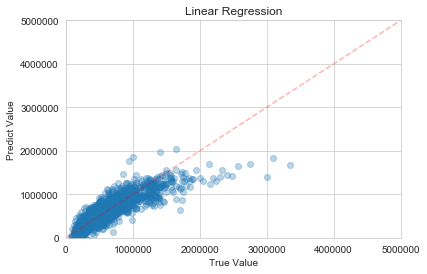

In [8]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MAE', round(mae, 2))
print('RMSE', round(rmse, 2))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot(range(0,5000000, 100), range(0,5000000, 100), '--r', alpha=0.3, label='Line1')
plt.title('Linear Regression')
plt.xlabel('True Value')
plt.ylabel('Predict Value')
plt.xlim([0, 5000000])
plt.ylim([0, 5000000])
plt.show()

# KNN

In [9]:
# Model Training
model = KNeighborsRegressor(n_neighbors=20)
#model.fit(X_train, y_train.ravel())
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [10]:
def evaluation_chart(test, pred, title):
    plt.scatter(test, pred, alpha=0.3)
    plt.plot(range(0,5000000, 100), range(0,5000000, 100), '--r', alpha=0.3, label='Line1')
    plt.title(title)
    plt.xlabel('True Value')
    plt.ylabel('Predict Value')
    plt.xlim([0, 5000000])
    plt.ylim([0, 5000000])
    plt.show()

MAE 104673.09
RMSE 168788.97


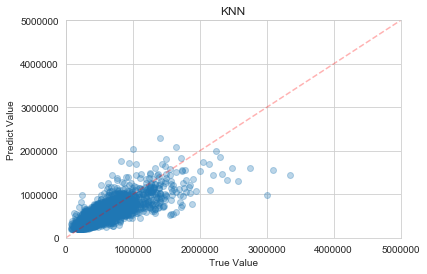

In [11]:
# model evaluation
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('MAE', round(mae, 2))
print('RMSE', round(rmse, 2))
evaluation_chart(y_test, y_pred, 'KNN')

# Decision Tree

In [12]:
def model_training(model, X_train, y_train, X_test):
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    return(y_pred)

def model_evaluation(title, model, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('MAE', round(mae, 2))
    print('RMSE', round(rmse, 2))
    for i in range(len(X_columns)):
        print([X_columns[i], model.feature_importances_[i]])
    evaluation_chart(y_test, y_pred, title)

def run_experiment(title, model, X_train, y_train, X_test, y_test):
    y_pred = model_training(model, X_train, y_train, X_test)
    model_evaluation(title, model, y_test, y_pred)

MAE 99108.48
RMSE 156178.67
['bedrooms', 0.016220120007934748]
['bathrooms', 0.03817849682934667]
['grade', 0.43284315480882535]
['condition', 0.011996110748171633]
['sqft_living15', 0.08729590414709537]
['sqft_lot15', 0.05119957127728823]
['floors', 0.010595802577854982]
['walking_score', 0.1180182883580248]
['median_income', 0.0046871633763152995]
['mean_income', 0.13505880507105902]
['population', 0.0385260795055216]
[98001, 4.362204128786619e-05]
[98002, 0.0004746482640179103]
[98003, 1.5184557758766918e-05]
[98004, 0.008384771621700735]
[98005, 0.0011148832858398727]
[98006, 0.0020128086765999536]
[98007, 0.0009104586212299474]
[98008, 0.0002277209808650547]
[98010, 5.466585800252681e-05]
[98011, 1.260012974843308e-05]
[98014, 5.3831600528280905e-05]
[98019, 1.1600186884517834e-05]
[98022, 0.0006161951327204386]
[98023, 5.836135992928928e-05]
[98024, 4.825121967900568e-06]
[98027, 3.634705854737028e-05]
[98028, 0.00036334005357767705]
[98029, 3.488744501507752e-05]
[98030, 8.93934

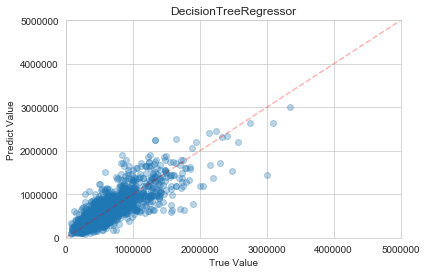

In [13]:
run_experiment('DecisionTreeRegressor', DecisionTreeRegressor(), X_train, y_train, X_test, y_test)

# Random Forest

MAE 75463.96
RMSE 120336.6
['bedrooms', 0.01695315816717672]
['bathrooms', 0.04238318981619528]
['grade', 0.4217757433206516]
['condition', 0.012279427600665391]
['sqft_living15', 0.09023476441988285]
['sqft_lot15', 0.048137504367790115]
['floors', 0.010130704557615281]
['walking_score', 0.09920052150879963]
['median_income', 0.020605745546872997]
['mean_income', 0.13144540091904497]
['population', 0.033067103683787596]
[98001, 0.00033985639150572983]
[98002, 0.0003047687266875217]
[98003, 0.00015853045553940556]
[98004, 0.017495036171152733]
[98005, 0.0007227048153874119]
[98006, 0.002164228667844643]
[98007, 0.00020906267003897652]
[98008, 0.00087143142710433]
[98010, 5.050421537863386e-05]
[98011, 0.000628747213934764]
[98014, 2.67802934564729e-05]
[98019, 4.5231748590105534e-05]
[98022, 9.096108134839197e-05]
[98023, 3.547526675422887e-05]
[98024, 2.7313764082802682e-05]
[98027, 6.377699949214501e-05]
[98028, 9.714696088090156e-05]
[98029, 5.173417961792752e-05]
[98030, 0.000283858

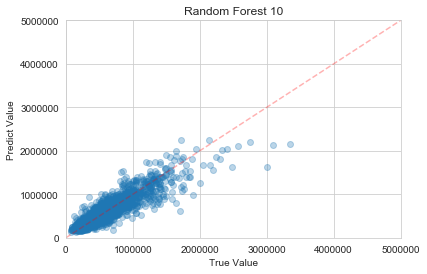

MAE 72233.25
RMSE 113979.18
['bedrooms', 0.017304879647002665]
['bathrooms', 0.040423425840321006]
['grade', 0.42807455662879745]
['condition', 0.012721523263860017]
['sqft_living15', 0.0896909496694473]
['sqft_lot15', 0.0495338290621832]
['floors', 0.00977212742481466]
['walking_score', 0.10044476424891506]
['median_income', 0.02214282603944007]
['mean_income', 0.11971096077076426]
['population', 0.03302425838638803]
[98001, 0.0003623141287965992]
[98002, 0.00019100522632873812]
[98003, 9.695670473167089e-05]
[98004, 0.01945393477073574]
[98005, 0.0009101243473625927]
[98006, 0.0018264858880740805]
[98007, 0.00021274150192683133]
[98008, 0.0005147663236804639]
[98010, 4.4302050206713844e-05]
[98011, 0.00042826958386642683]
[98014, 4.890066546415234e-05]
[98019, 3.157562473219543e-05]
[98022, 0.00021916365425290842]
[98023, 7.19158791591908e-05]
[98024, 4.196410870521752e-05]
[98027, 9.309581631944692e-05]
[98028, 0.00016938765170184568]
[98029, 5.231262251078403e-05]
[98030, 0.0001585

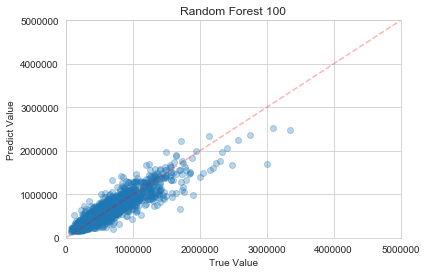

In [14]:
run_experiment('Random Forest 10', RandomForestRegressor(n_estimators=10), X_train, y_train, X_test, y_test)
run_experiment('Random Forest 100', RandomForestRegressor(n_estimators=100), X_train, y_train, X_test, y_test)

# Loop

In [15]:
def model_training(model, X_train, y_train, X_test):
    model.fit(X_train, y_train.values.ravel())
    y_pred = model.predict(X_test)
    return(y_pred)

def model_evaluation(title, model, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(title)
    print('MAE', round(mae, 2))
    print('RMSE', round(rmse, 2))
    evaluation_chart(y_test, y_pred, title)
    importance = []
    if hasattr(model, 'feature_importances_'):
        print('Feature Importance')
        importance = []
        for i in range(len(X_columns)):
            importance.append([X_columns[i], model.feature_importances_[i]])
        print(pd.DataFrame(importance).sort_values(by=1, ascending=False).head(10))
    return(mae, rmse)

def run_experiment(title, model, X_train, y_train, X_test, y_test):
    y_pred = model_training(model, X_train, y_train, X_test)
    mae, rmse = model_evaluation(title, model, y_test, y_pred)
    return(mae, rmse)

LinearRegression
MAE 91411.45
RMSE 140108.31


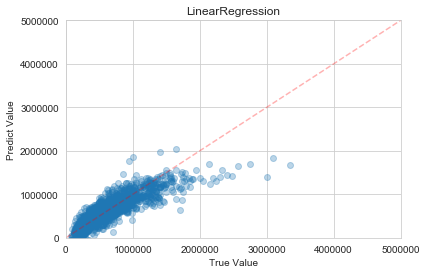

RandomForestRegressor10
MAE 75404.66
RMSE 119381.87


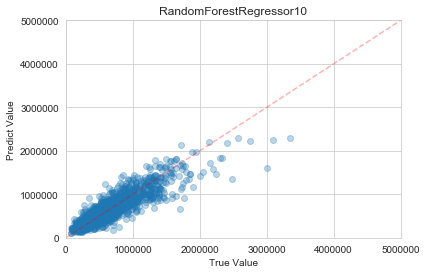

Feature Importance
                0         1
2           grade  0.432906
9     mean_income  0.123794
7   walking_score  0.100165
4   sqft_living15  0.087112
5      sqft_lot15  0.049332
1       bathrooms  0.042954
10     population  0.026453
8   median_income  0.024841
54          98105  0.017426
0        bedrooms  0.017204
RandomForestRegressor100
MAE 72157.06
RMSE 113876.91


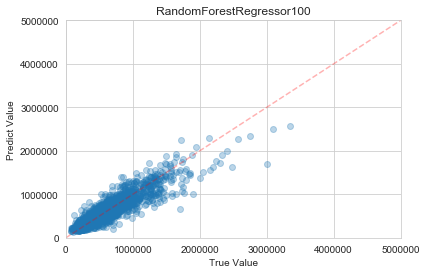

Feature Importance
                0         1
2           grade  0.425263
9     mean_income  0.116151
7   walking_score  0.099654
4   sqft_living15  0.088966
5      sqft_lot15  0.049940
1       bathrooms  0.043044
10     population  0.037164
8   median_income  0.021888
14          98004  0.020398
0        bedrooms  0.017461
KNeighborsRegressor
MAE 104033.0
RMSE 169832.51


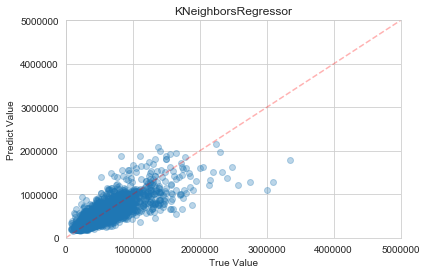

DecisionTreeRegressor
MAE 99668.58
RMSE 157707.35


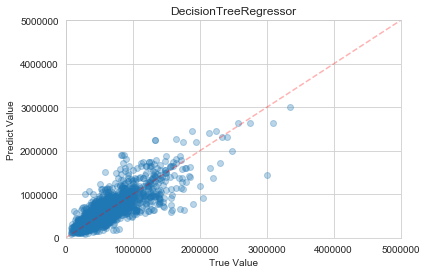

Feature Importance
                0         1
2           grade  0.432293
9     mean_income  0.132924
7   walking_score  0.117541
4   sqft_living15  0.088529
5      sqft_lot15  0.050403
1       bathrooms  0.038095
10     population  0.023386
8   median_income  0.020927
54          98105  0.017332
0        bedrooms  0.016148


,model,mae,rmse
2,RandomForestRegressor100,72157.056978,113876.909361
1,RandomForestRegressor10,75404.663135,119381.866133
0,LinearRegression,91411.450454,140108.305942
4,DecisionTreeRegressor,99668.584987,157707.354492
3,KNeighborsRegressor,104033.000756,169832.507753


In [16]:
models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
    ('RandomForestRegressor100', RandomForestRegressor(n_estimators=100)),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor()),
]
results = []
for m in models:
    mae, rmse = run_experiment(m[0], m[1], X_train, y_train, X_test, y_test)
    results.append([m[0], mae, rmse])
    
# sort the results and print as a table
df_results = pd.DataFrame(results)
df_results.columns = ['model', 'mae', 'rmse']
df_results = df_results.sort_values(by='mae')
df_results

In [19]:
models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
    ('RandomForestRegressor100', RandomForestRegressor(n_estimators=100, n_jobs=4)),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor())
]

k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'mae':[], 'rmse':[]}
    kf = KFold(n_splits=k, shuffle=True)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[m[0]]['mae'].append(mae)
        results[m[0]]['rmse'].append(rmse)

MODEL LinearRegression
MODEL RandomForestRegressor10
MODEL RandomForestRegressor100
MODEL KNeighborsRegressor
MODEL DecisionTreeRegressor


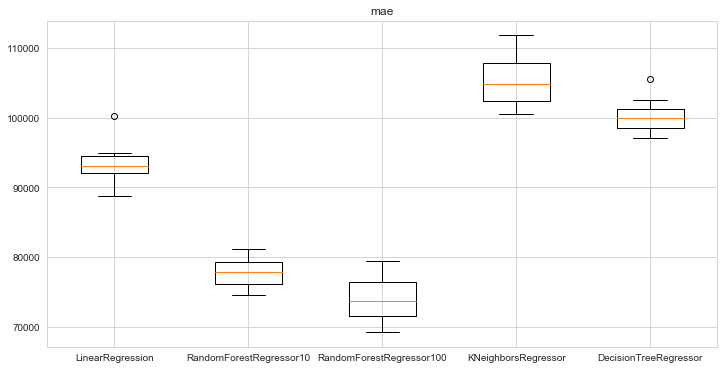

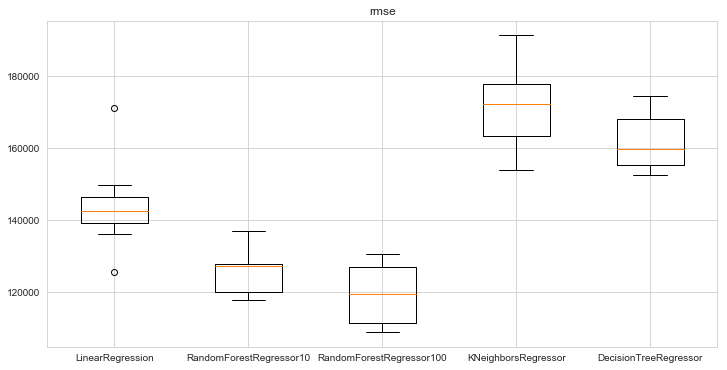

In [20]:
for metric in ['mae', 'rmse']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()

# Error Analysis

In [21]:
# Model Training
model = RandomForestRegressor(n_estimators=100, n_jobs=4)
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test)

In [22]:
df_test = pd.DataFrame(X_test)
df_test.columns = X_columns
df_test['price'] = y_test
df_test['prediction'] = y_pred
df_test['error'] = abs(df_test['price']-df_test['prediction'])
df_test.sort_values(by='error', ascending=False).round()

,bedrooms,bathrooms,grade,condition,sqft_living15,sqft_lot15,floors,walking_score,median_income,mean_income,...,98166,98168,98177,98178,98188,98198,98199,price,prediction,error
1017,5.0,3.0,9.0,3.0,3850.0,36563.0,2.0,71.0,128906.0,187222.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2700000.0,1332829.0,1367171.0
1925,5.0,3.0,10.0,3.0,2410.0,12047.0,2.0,56.0,99669.0,144248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000000.0,1656988.0,1343012.0
780,5.0,5.0,11.0,3.0,3160.0,17825.0,2.0,2.0,174729.0,289887.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3418800.0,2360222.0,1058578.0
1687,4.0,4.0,12.0,4.0,2980.0,19602.0,2.0,2.0,174729.0,289887.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3710000.0,2752332.0,957668.0
1423,5.0,5.0,11.0,3.0,4170.0,17668.0,1.0,71.0,128906.0,187222.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2950000.0,1994332.0,955668.0
1735,3.0,4.0,11.0,3.0,4040.0,12333.0,2.0,56.0,99669.0,144248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1825000.0,2663757.0,838757.0
491,4.0,2.0,10.0,3.0,2830.0,13732.0,2.0,56.0,99669.0,144248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,782000.0,1457695.0,675695.0
769,6.0,3.0,8.0,4.0,2590.0,4550.0,2.0,85.0,67705.0,99361.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700000.0,1318580.0,618580.0
1156,3.0,2.0,8.0,3.0,2190.0,9540.0,1.0,47.0,93940.0,122972.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1289000.0,684251.0,604749.0
625,3.0,2.0,9.0,3.0,2570.0,7988.0,1.0,18.0,89013.0,109567.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1300000.0,735294.0,564706.0


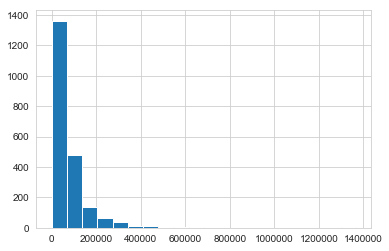

In [23]:
plt.hist(df_test['error'], bins=20)
plt.show()

In [24]:
df_test[df_test['error']>600000]

,bedrooms,bathrooms,grade,condition,sqft_living15,sqft_lot15,floors,walking_score,median_income,mean_income,...,98166,98168,98177,98178,98188,98198,98199,price,prediction,error
491,4.0,2.50,10.0,3.0,2830.0,13732.0,2.0,56.0,99669.0,144248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,782000.0,1457695.00,675695.00
769,6.0,3.00,8.0,4.0,2590.0,4550.0,2.5,85.0,67705.0,99361.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,700000.0,1318580.00,618580.00
780,5.0,5.00,11.0,3.0,3160.0,17825.0,2.0,2.0,174729.0,289887.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3418800.0,2360221.90,1058578.10
1017,5.0,2.75,9.0,3.0,3850.0,36563.0,2.0,71.0,128906.0,187222.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2700000.0,1332828.90,1367171.10
1156,3.0,2.50,8.0,3.0,2190.0,9540.0,1.0,47.0,93940.0,122972.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1289000.0,684250.58,604749.42
1423,5.0,4.75,11.0,3.0,4170.0,17668.0,1.0,71.0,128906.0,187222.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2950000.0,1994332.00,955668.00
1687,4.0,3.50,12.0,4.0,2980.0,19602.0,2.0,2.0,174729.0,289887.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3710000.0,2752332.30,957667.70
1735,3.0,3.75,11.0,3.0,4040.0,12333.0,2.0,56.0,99669.0,144248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1825000.0,2663757.00,838757.00
1925,5.0,3.25,10.0,3.0,2410.0,12047.0,2.0,56.0,99669.0,144248.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000000.0,1656988.50,1343011.50


In [25]:
df_test.corr()['error'].sort_values()

population      -0.063447
98038           -0.059121
98030           -0.058291
98023           -0.053905
98168           -0.052125
98058           -0.051984
98031           -0.049495
98042           -0.048720
98002           -0.047260
98092           -0.044884
98055           -0.043785
98029           -0.043114
98003           -0.041903
98059           -0.038264
98065           -0.036242
98001           -0.033876
98056           -0.033380
98034           -0.030788
98045           -0.029378
98148           -0.027663
98178           -0.025205
98007           -0.024847
98022           -0.023061
98032           -0.023016
98028           -0.022858
98117           -0.021691
98052           -0.021230
98108           -0.021032
98106           -0.019154
98155           -0.018499
                   ...   
98008            0.020792
98122            0.023694
sqft_lot15       0.029532
98177            0.032626
98033            0.038410
98103            0.038914
98119            0.040277
floors      

In [26]:
df.groupby('zipcode')['price'].mean().round().sort_values()

zipcode
98002     234284.0
98168     238009.0
98032     248928.0
98148     273986.0
98001     276637.0
98023     279993.0
98188     280473.0
98198     283964.0
98003     284387.0
98178     293930.0
98031     294436.0
98030     295134.0
98055     301620.0
98042     303617.0
98022     304324.0
98106     312285.0
98092     322294.0
98146     338274.0
98058     342939.0
98108     355679.0
98038     357789.0
98133     380019.0
98155     401462.0
98118     402807.0
98056     407292.0
98019     415831.0
98126     416834.0
98010     423666.0
98045     424817.0
98014     426500.0
           ...    
98072     557694.0
98107     561628.0
98117     563718.0
98024     569857.0
98103     570617.0
98027     588274.0
98008     592259.0
98029     592728.0
98007     598184.0
98116     599909.0
98122     599934.0
98115     603854.0
98177     627365.0
98052     633543.0
98053     655457.0
98074     661827.0
98077     665689.0
98033     755748.0
98199     757828.0
98075     766802.0
98005     778336.0
9811

In [27]:
df.groupby('zipcode')['price'].count().round().sort_values()

zipcode
98039     48
98148     55
98024     79
98010    100
98102    101
98109    107
98070    115
98014    121
98032    124
98188    133
98007    135
98005    163
98119    177
98108    186
98019    187
98011    192
98077    195
98002    199
98105    216
98045    218
98022    228
98166    248
98177    249
98030    255
98178    256
98136    259
98112    261
98107    263
98055    265
98168    267
        ... 
98004    308
98199    310
98029    315
98116    324
98106    327
98144    332
98092    341
98126    349
98075    353
98001    357
98053    397
98125    399
98056    402
98027    402
98033    421
98074    433
98155    439
98058    447
98059    454
98133    481
98006    485
98023    493
98118    499
98034    533
98042    537
98117    541
98052    566
98115    574
98038    580
98103    589
Name: price, Length: 70, dtype: int64

In [28]:
df_income = df.groupby('zipcode')['mean_income', 'median_income'].mean().sort_values('zipcode')
df_income['diff'] = abs(df_income['mean_income']-df_income['median_income'])/df_income['median_income']
df_income.sort_values('diff', ascending=False)

,mean_income,median_income,diff
zipcode,,,
98039,289887.0,174729.0,0.659066
98105,79895.0,52145.0,0.532170
98112,137945.0,90529.0,0.523766
98102,85545.0,57724.0,0.481966
98119,99361.0,67705.0,0.467558
98040,187222.0,128906.0,0.452392
98004,144248.0,99669.0,0.447270
98166,87031.0,62107.0,0.401307
98144,80542.0,58263.0,0.382387


# Model Training / Evaluation - Cross Validation

In [29]:
models = [
    ('LinearRegression', LinearRegression()),
    ('RandomForestRegressor10', RandomForestRegressor(n_estimators=10)),
    ('RandomForestRegressor100', RandomForestRegressor(n_estimators=100, n_jobs=4)),
    ('KNeighborsRegressor', KNeighborsRegressor()),
    ('DecisionTreeRegressor', DecisionTreeRegressor())
]

k = 10
results = {}
for m in models:
    print('MODEL', m[0])
    results[m[0]] = {'mae':[], 'rmse':[]}
    kf = KFold(n_splits=k)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        model = m[1]
        model.fit(X_train, y_train.ravel())
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        results[m[0]]['mae'].append(mae)
        results[m[0]]['rmse'].append(rmse)

MODEL LinearRegression
MODEL RandomForestRegressor10
MODEL RandomForestRegressor100
MODEL KNeighborsRegressor
MODEL DecisionTreeRegressor


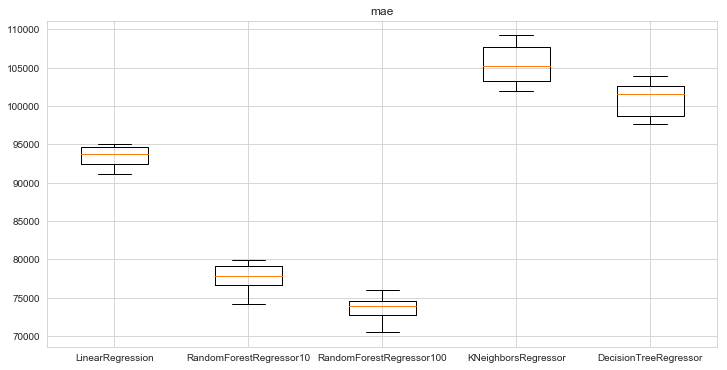

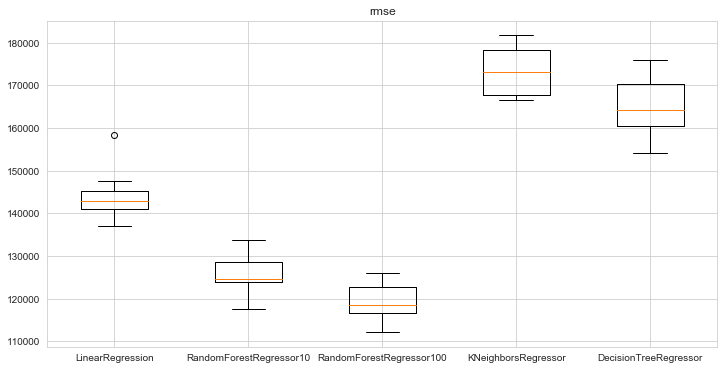

In [30]:
for metric in ['mae', 'rmse']:
    values = []
    labels = []
    for model, result_values in results.items():
        for m, v in result_values.items():
            if m == metric:
                labels.append(model)
                values.append(v)
    plt.figure(figsize=(12,6))
    plt.title(metric)
    plt.boxplot(values)
    plt.xticks(range(1, len(labels)+1), labels, rotation='horizontal')
    plt.show()